# DEM-GNN Rollout Evaluation

## Import dependencies

In [1]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm, trange

print(torch.cuda.is_available())
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200)

True


## Loading and training on datasets

In [ ]:
from Plotting import PlotTrainingLoss
dataset_name="2Sphere"
model_ident = "Allout_Push"
try: fig, axs = PlotTrainingLoss(dataset_name,model_ident)
except: print("Failed plot")

## Generating Rollouts

In [ ]:
from Evaluation import CompareModels, Evaluation
Evaluation_function=Evaluation(mode='mechanics_mean',print_results=True)
#model_idents = ["Allout",'Forward_Bundle','Forward','Bundle', 'Onestep']
metrics = CompareModels(dataset_name        = 'N400_Mono',
                        model_idents        = ['Test16','Test32','Test64','Test128'],
                        Evaluation_function = Evaluation_function)

In [ ]:
metrics = CompareModels(dataset_name        = '2Sphere',
                        model_idents        = ['Allout'],
                        Evaluation_function = Evaluation_function)

In [2]:
from Plotting import PlotXYZ, PlotStressComparison
from ML_functions import LearnedSimulator, NormalizeData, GetModel, Rescale, NormalizePos, MaskTestData

dataset_name="2Sphere"
model_ident = "Onestep"

model = GetModel(dataset_name,model_ident)[0]
AggregatedArgs = MaskTestData(dataset_name,"test")

Loaded model 2Sphere_Onestep


Calculating BC


100%|██████████| 100/100 [00:00<00:00, 50009.59it/s]


100%|██████████| 100/100 [00:00<00:00, 847.46it/s]


Calculating Learned Rollout


100it [00:00, 146.02it/s]                       


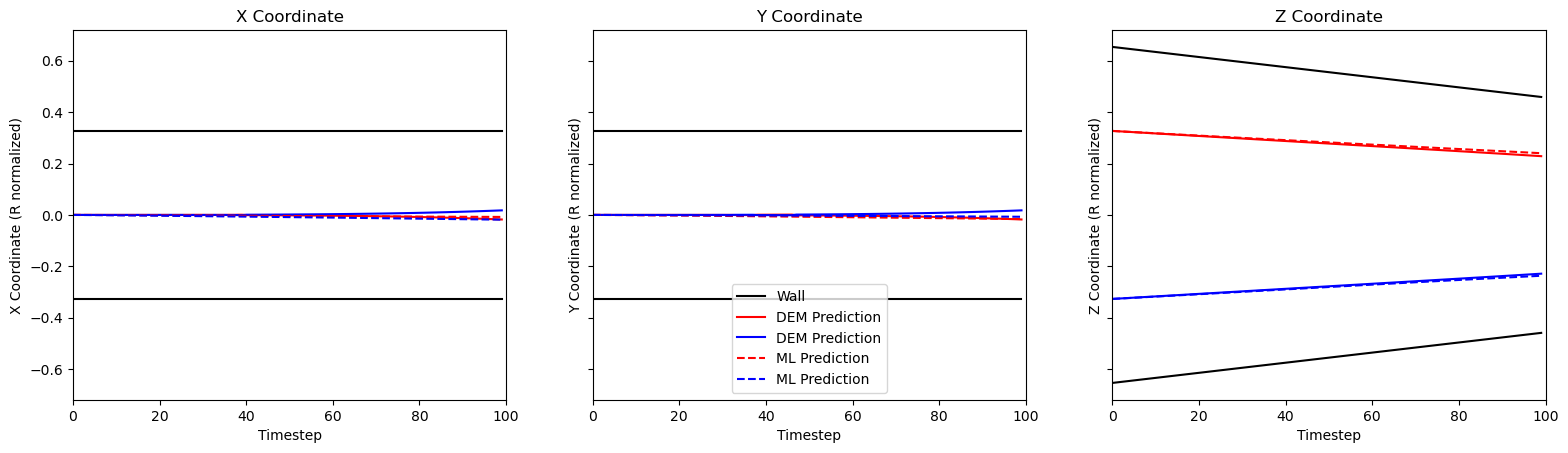

In [3]:
scale_name = f"{dataset_name}_bund{model.bundle_size}"
transform = T.Compose([T.Cartesian(False),T.Distance(norm=False,cat=True),NormalizeData(dataset_name,scale_name)])
Simulation = LearnedSimulator(model, scale_function = Rescale(dataset_name,scale_name),transform = transform)
for sample_idx in [0]:
    Simulation.Rollout(*AggregatedArgs,sample_idx,show_tqdm=True)
    if dataset_name == "2Sphere": 
        PlotXYZ(Simulation,t_max=100, normalize=False)
        #PlotStressComparison(Simulation,plot_ml=True)


In [ ]:
DEM_data_array = np.array([np.concatenate((data.pos[data.mask],data.x[data.mask]),axis=1) for data in Simulation.GroundTruth])

In [ ]:
DEM_data_array[0]

In [ ]:
DEM_data_array[:,0,2]
fig, axes = plt.subplots(1,3,sharey=True)
fig.set_figwidth(19)
par_data = AggregatedArgs[0][0]
par_data[:,0,2]
axes[0].plot(DEM_data_array[:,0,2])
axes[1].plot(par_data[:,0,2])

In [ ]:
np.array([data.x for data in Simulation.ML_rollout])[4]

In [ ]:
Simulation.BC_rollout.shape

## Evaluating Rollouts

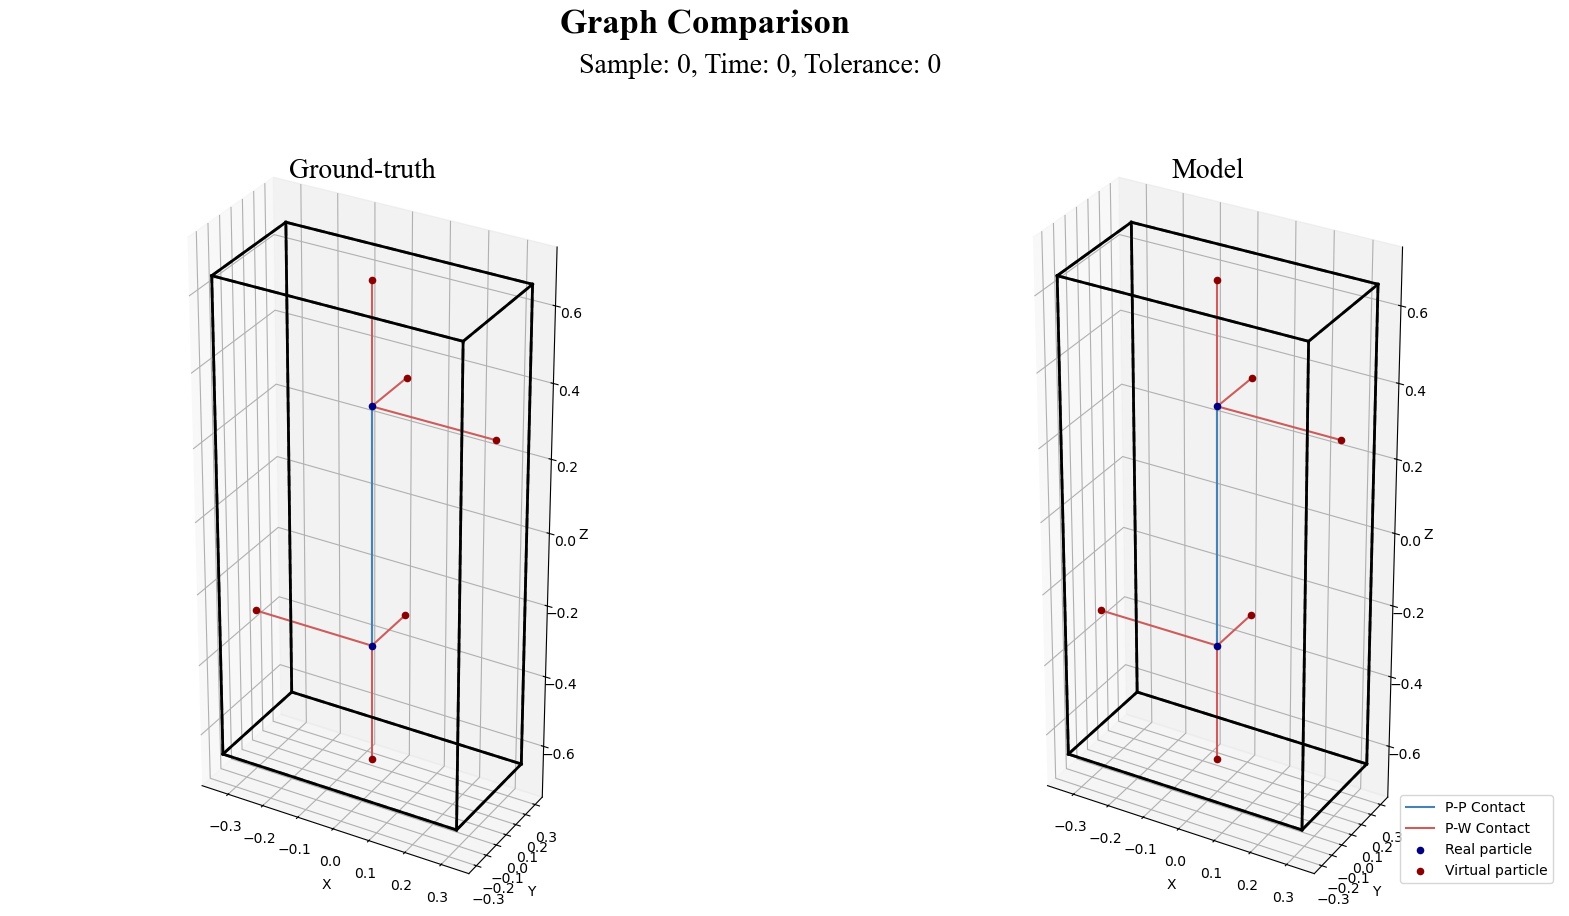

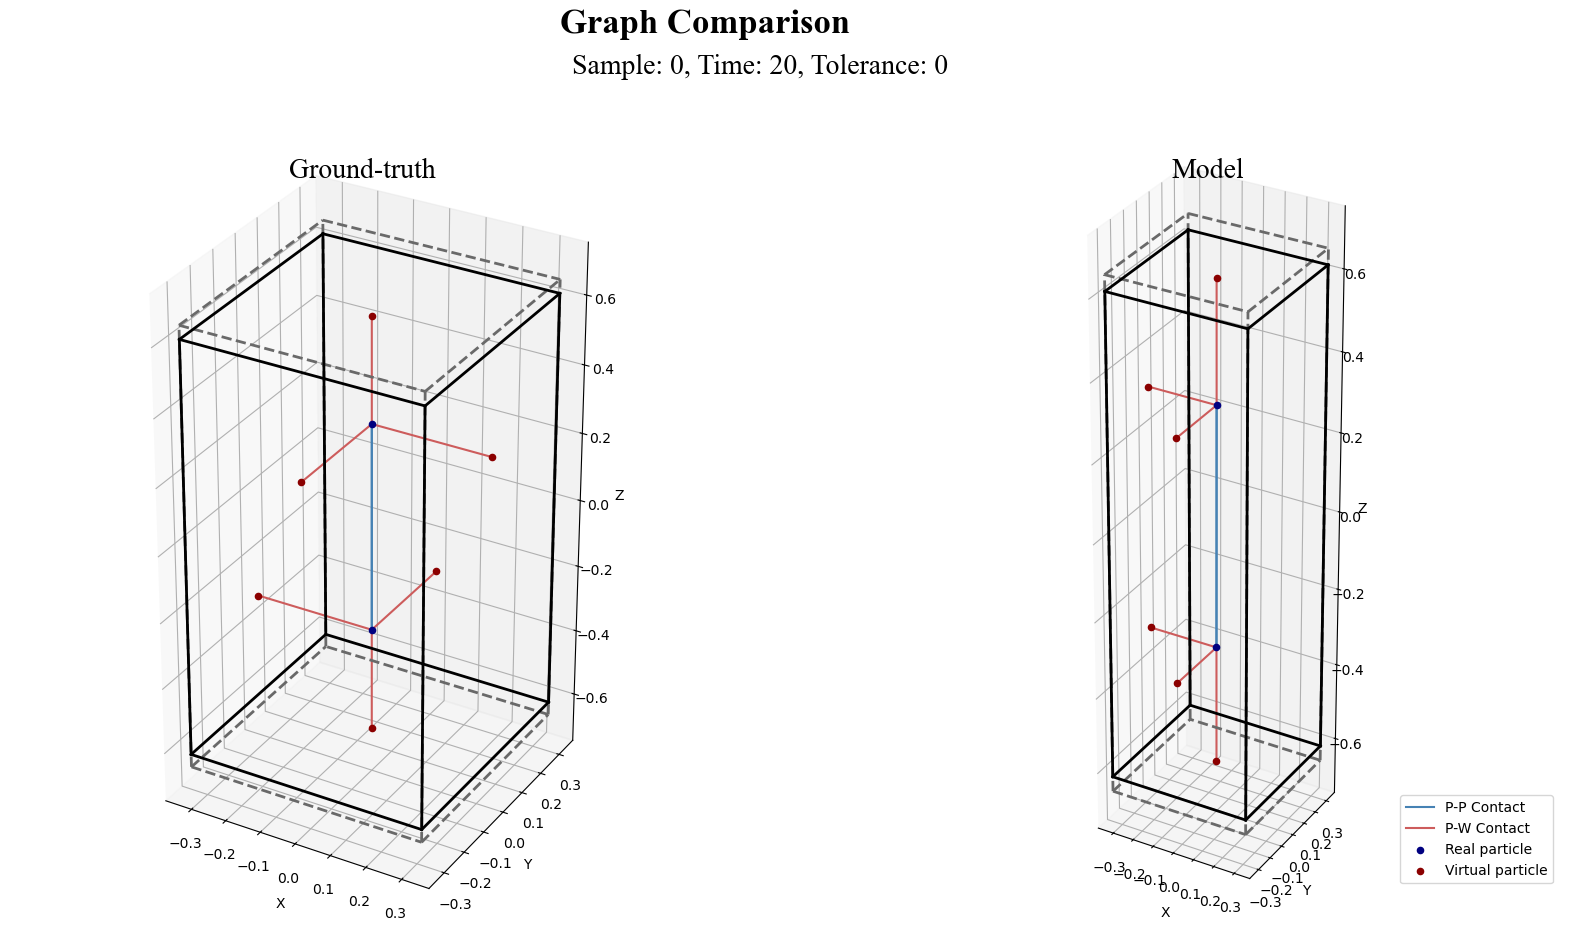

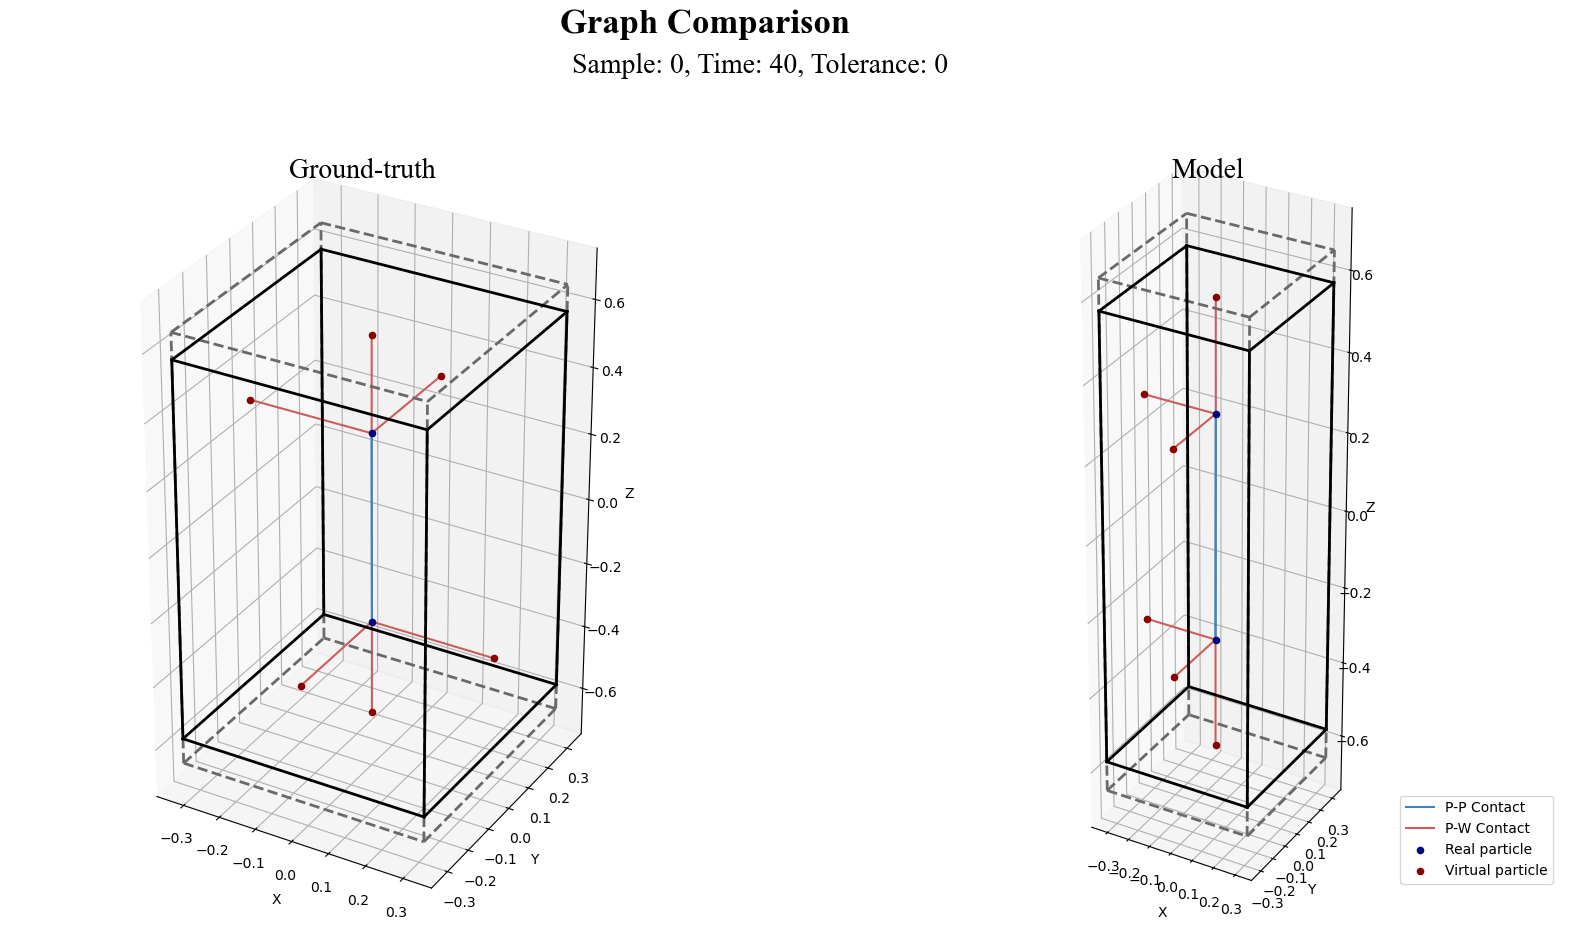

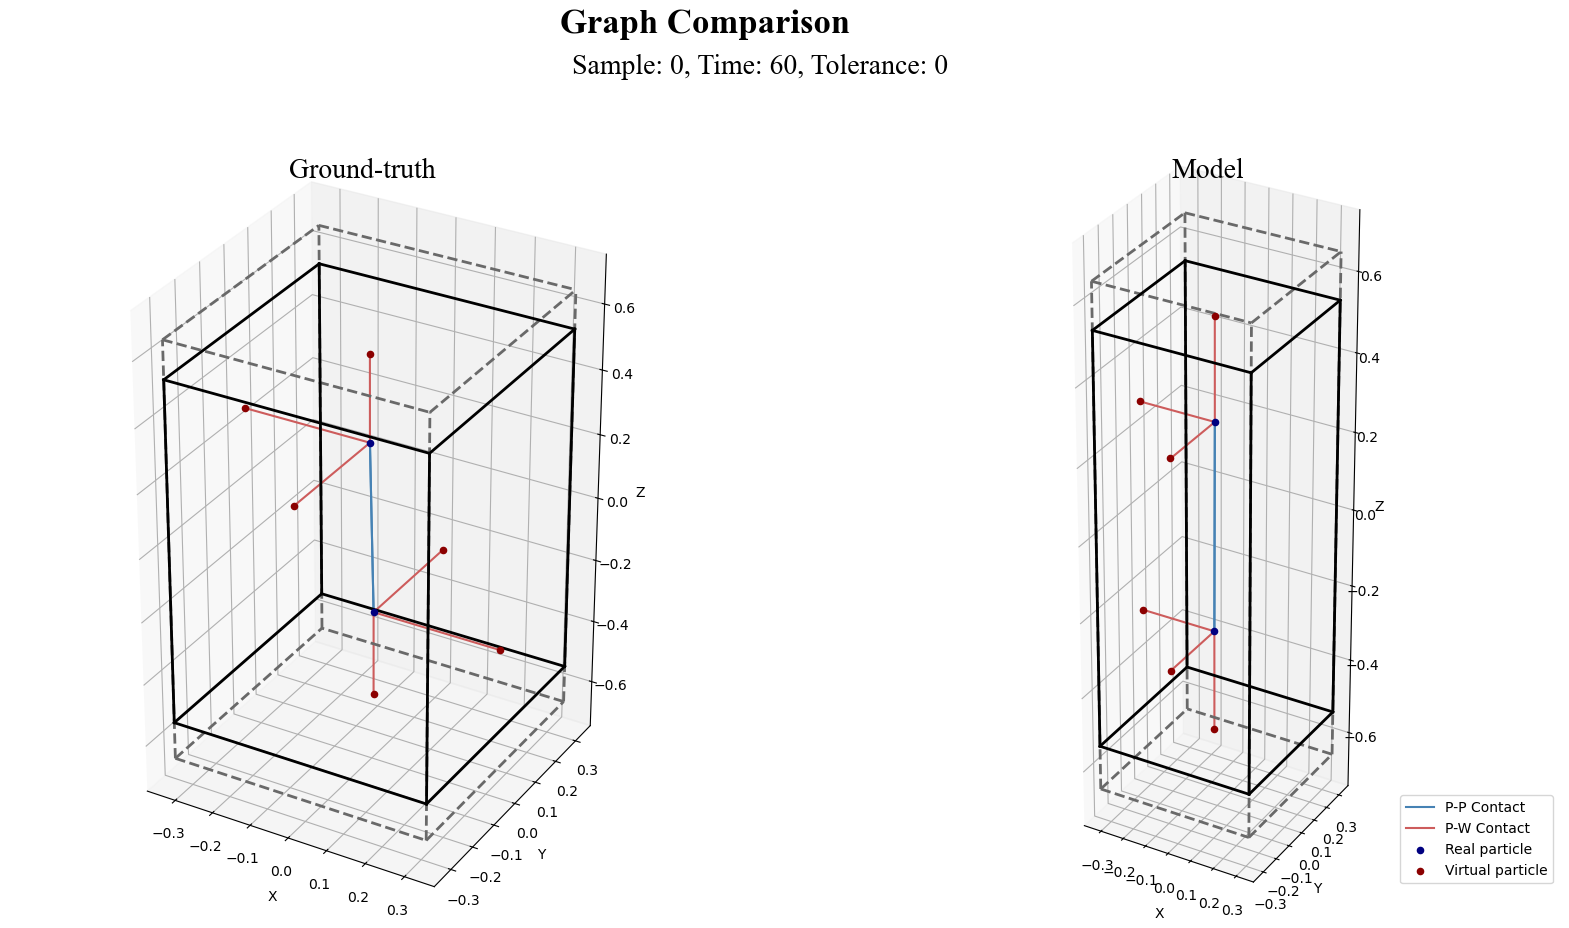

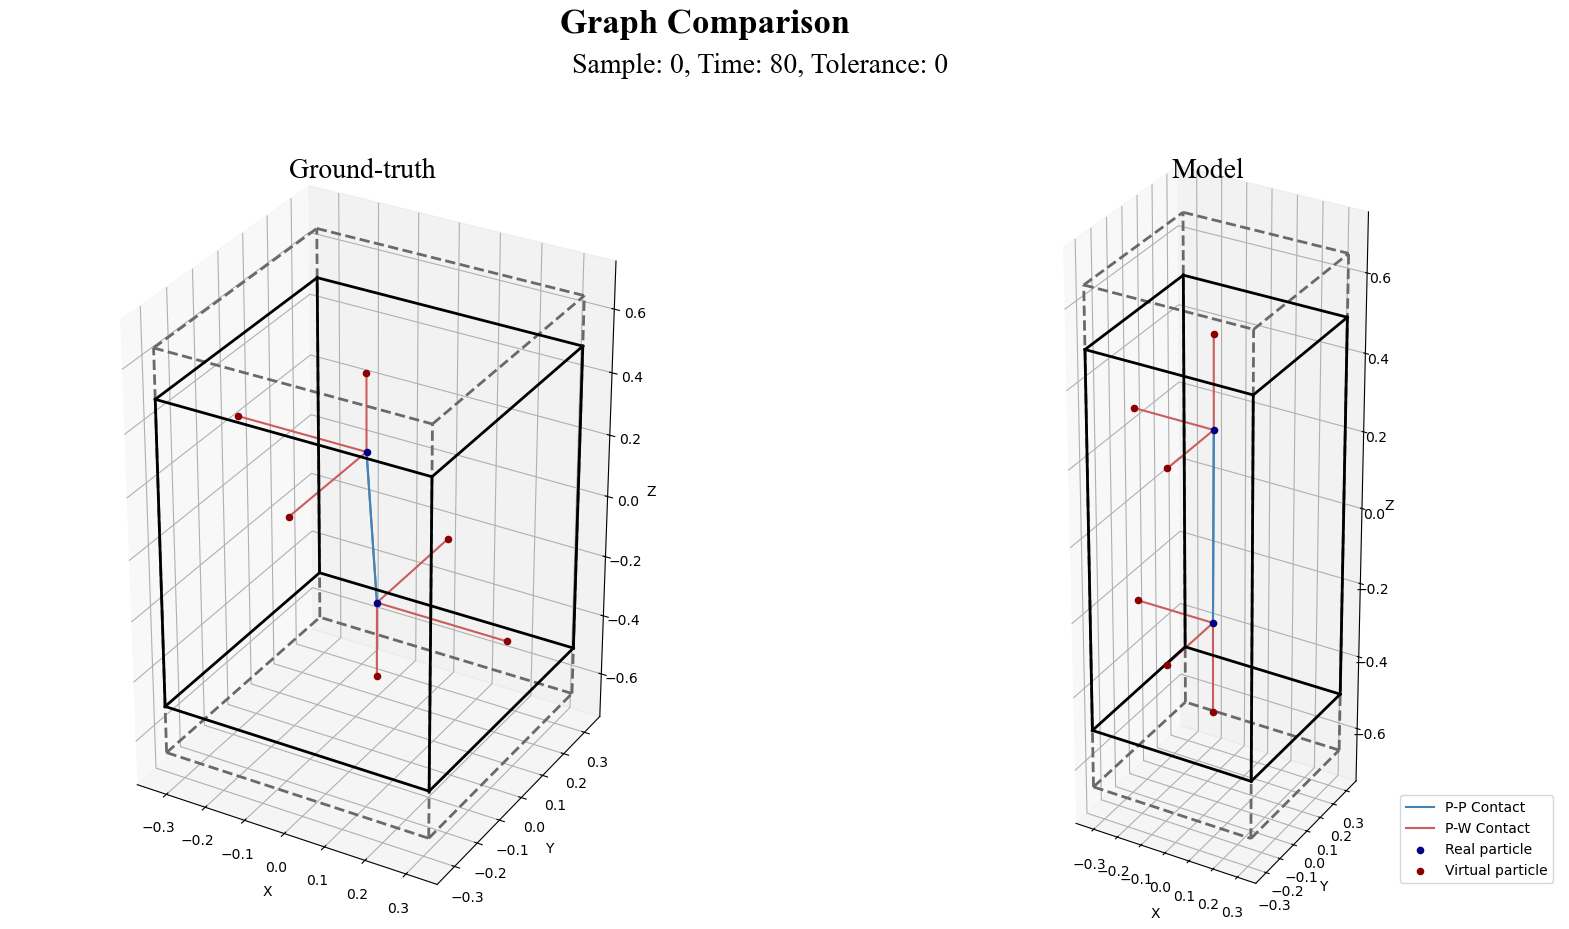

In [4]:
from Plotting import PlotGraphComparison
save = False
show = True
for t in range(0,100,20):  
    fig = PlotGraphComparison(t,Simulation,sample_idx,Simulation.tol,plot_lines=True)
    if save == True: plt.savefig(f"{os.getcwd()}\\Figures\\Plots\\Graph_Sample{sample_idx}_Time{t}_Tol{str(Simulation.tol)[2:]}.png",bbox_inches='tight')     
    if show == True: plt.show()

In [ ]:
from Plotting import PlotFres
from Evaluation import NormalizedResultantForce
list = [NormalizedResultantForce(data) for data in Simulation.GroundTruth]
Fnorm_ML = np.array([NormalizedResultantForce(data) for data in Simulation.ML_rollout])
Fnorm_GT = np.array([NormalizedResultantForce(data) for data in Simulation.GroundTruth])
fig = PlotFres(np.mean(Fnorm_GT,axis=1),np.mean(Fnorm_ML,axis=1))

In [ ]:
from Plotting import PlotForceDistributionComparison
quantiles = [5,10,25,50]
fig, ax = PlotForceDistributionComparison(Fnorm_GT,Fnorm_ML,quantiles,True)

In [ ]:
import pyvista as pv
from Plotting import MakeGIF, PlotMeshNormals

gifname = f"{dataset_name}_GT_deform"
#gifname = f"{dataset_name}_{model_ident}_deform"

datalist = Simulation.GroundTruth
#datalist = Simulation.ML_rollout
MakeGIF(datalist,gifname,fps=8,color='lightblue',deformation=True)

#data = Rollout.ML_rollout[10]
#data = Rollout.GroundTruth[0]
#PlotMeshNormals(data)


## Testing New Code

### Benchmarking topology functions

In [ ]:
from Encoding import ConstructTopology
from ML_functions import MaskTestData
dataset_name = 'N400_Mono'
AggregatedArgs = MaskTestData(dataset_name,'test')
data,top,bc = AggregatedArgs
data = data[0]
top = top[0]
bc = bc[0]
t=0
BC_t = bc.copy()
BC_t[:,:3] = bc[:,:3]+(t+1)*bc[:,-3:]


par_data = data[0]
super_topology = ConstructTopology(par_data,BC_t,6)-1

In [ ]:
data,top,bc = AggregatedArgs
top.shape

In [ ]:
from Encoding import TopologyFromPlausibleTopology_old, TopologyFromPlausibleTopology

tol=0
t0 = time.time()
topology_0 = ConstructTopology(par_data,BC_t,tol)-1
t1 = time.time()
topology_1 = TopologyFromPlausibleTopology_old(super_topology,par_data,BC_t,tol)
t2 = time.time()
topology_2 = TopologyFromPlausibleTopology(super_topology,par_data,BC_t,tol)
t3 = time.time()

print(np.all(topology_0 == topology_1))
print(np.all(topology_1 == topology_2))
print(t1-t0)
print(t2-t1)
print(t3-t2)

In [ ]:
AggregatedArgs = MaskTestData(dataset_name)
data,top,bc = AggregatedArgs
par_data = data[0][0]
print(par_data)
R_avg = par_data[0,3]
noise_factor = 0.01
standard_deviation = noise_factor*R_avg
noise = np.array(standard_deviation*torch.randn((par_data.shape[0],3)))
par_data[:,:3]+=noise
print(par_data)

In [ ]:
t=40
BC_t = bc.copy()
BC_t[:,:3] = bc[:,:3]+(t+1)*bc[:,-3:]
bc=BC_t
par_data = data[t]
top0 = ConstructTopology(par_data,bc,0)-1

from Encoding import TopologyFromPlausibleTopology
topology_sub = TopologyFromPlausibleTopology(super_topology,par_data,BC_t,0)

topology_sub == top0,topology_sub

In [ ]:
from Evaluation import GetGamma
gamma = GetGamma(data)
gamma

### Testing normalization

In [ ]:
def AverageDX(data):
    norm = torch.norm(data.y,dim=1)
    return torch.mean(norm)

dataset_test.y.abs().mean().item()

In [ ]:
def PrintDatasetStats(dataset):
    torch.set_printoptions(sci_mode=False, linewidth=150)
    print(f"x_max:      {dataset.x.max(dim=0)[0]}")
    print(f"y_mean:     {dataset.y.mean(dim=0)}")
    print(f"y_std:      {dataset.y.std(dim=0)}")
    print(f"edge_mean:  {dataset.edge_attr.mean(dim=0)}")
    print(f"edge_std:   {dataset.edge_attr.std(dim=0)}")
    print("\n")
    torch.set_printoptions(profile='default')

PrintDatasetStats(dataset_train)
#PrintDatasetStats(dataset_train_push)

fig = plt.hist(dataset_train_push.push_forward_steps,100)

## Old Code

In [ ]:
def FilterStart(dataset):
    idx = np.nonzero([data.time == 0 for data in dataset])
    return torch.utils.data.Subset(dataset_test,idx)[0]

#dataset_test_start = FilterStart(dataset_test)

In [ ]:
from Encoding import ToPytorchData, GetLength

def GetLimits(data):
    max = [torch.max(data.x[:,i]) for i in [0, 1, 2]]
    min = [torch.min(data.x[:,i]) for i in [0, 1, 2]]
    max = torch.stack(max)
    min = torch.stack(min)
    limits = torch.stack([min,max],dim=1)
    return limits


In [ ]:
from Encoding import load
def SplitData(dataset_name,data_split):
    loaded_data = load(dataset_name)
    splits=np.array(data_split)*loaded_data[0].shape[0]
    test_data = [np.split(data,splits.astype(int))[2] for data in loaded_data]
    return test_data

In [ ]:
from Evaluation import GetContactForce
from Encoding import ConvertToDirected
data = Rollout.GroundTruth[0].clone()
force = GetContactForce(data)
GT = np.loadtxt('PairContact001.txt')

data =ConvertToDirected(data)
force2 = GetContactForce(data)

print(torch.norm(force,dim=1).size())
print(torch.norm(force2,dim=1))

torch.all(np.round(GT[:,2],2)==torch.round(torch.norm(force2,dim=1),decimals=2))

In [ ]:
from Plotting import GetInternalStressRollout
stress = GetInternalStressRollout(Rollout)
torch.set_printoptions(4)
print("Stress at time 0")
print(torch.round(stress[0],decimals=8)),
print("\nStress at time 99")
print(torch.round(stress[-1],decimals=1))

In [ ]:
from Plotting import PlotContactVectorAndForce, GetAllContactpoints,AxesLimits
data = Rollout.GroundTruth[0]
BC = Rollout.BC_rollout[3]
fig,axs = PlotContactVectorAndForce(data,BC)
for ax in axs: AxesLimits(ax,BC)

In [ ]:
data = Rollout.ML_rollout[0]
#data = Rollout.GroundTruth[0]